In [60]:
# Making sure we have tensorflow version as 2.20
import tensorflow as tf
print(tf.__version__)

2.5.0


*   Importing keras libraries for creation of custom models, image preprocessing, and using different layers. 
*   Importing matplotlib for image plot
*   Importing PIL for image display.

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
from PIL import Image
import time
import numpy as np

In [62]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Methods defined**:
1. load_image:
Takes in path of the image. The image is resized and it broadcasted to include a batch dimension.

2. imshow():
Takes in the image and squeezes out the batch dimension and is used to display the image.

In [63]:
def load_image(path):
  max_dim = 512
  img = Image.open(path)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  img = kp_image.img_to_array(img)
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)

Here, we define the directories and paths for our images. 
Also, we have displayed our content image and style images. 

Content image shape :  (1, 512, 341, 3)
Style image shape :  (1, 341, 512, 3)


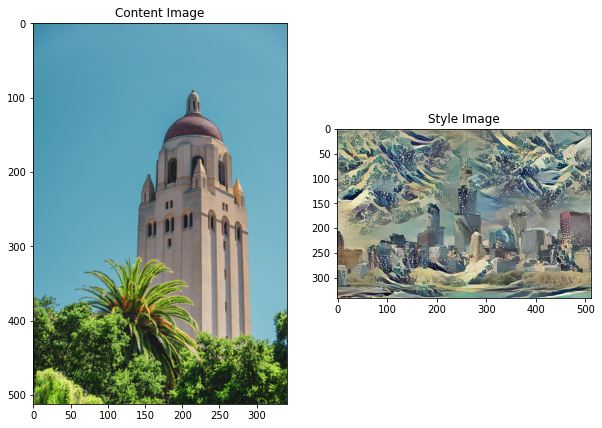

In [64]:
base_dir = '/content/gdrive/My Drive/Sem_6-Expt/Tensorflow/dataset'

content_path = base_dir + '/content/content_3.jpg'
content_img = load_image(content_path)
print('Content image shape : ',content_img.shape)

style_path = base_dir + '/style/style_3.png'
style_img = load_image(style_path)
print('Style image shape : ',style_img.shape) 

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
imshow(content_img,title='Content Image')

plt.subplot(1,2,2)
imshow(style_img,title='Style Image')

For content loss, we select the second convolution layer from the fifth block of VGG19. <br>

For style loss, we select first convolutional layer from block numbers 1 to 5 of VGG19. 

Reason for using VGG19: VGG19 is a well known feature extractor and it was also used by the authors in their original implementation.


In [65]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

This function is used to instantiate the VGG19 model. This is done using the outputs which we have defined earlier for content loss and style loss.  

In [66]:
def get_model():
  vgg = tf.keras.applications.vgg19.VGG19(weights='imagenet',include_top=False)
  vgg.trainable = False

  style_output = []
  for name in style_layers:
    layer = vgg.get_layer(name)
    layer_output = layer.output
    style_output.append(layer_output)
  
  content_output = []
  for name in content_layers:
    layer = vgg.get_layer(name)
    layer_output = layer.output
    content_output.append(layer_output)

  model_output = style_output + content_output
  model = models.Model(inputs = vgg.input,outputs = model_output)
  return model

Here, the images are preprocessed as per the requirements for VGG19. Then, we pass these images to the model to get style outputs and content outputs for each of the images. After that, we extract style features from style image, and content features from content image. 

In [67]:
preprocessed_content_image = tf.keras.applications.vgg19.preprocess_input(content_img)
preprocessed_style_image = tf.keras.applications.vgg19.preprocess_input(style_img)
print(preprocessed_style_image.shape)

model = get_model()
# compute content and style features
style_outputs = model(preprocessed_style_image)
content_outputs = model(preprocessed_content_image)
 
# Get the style and content feature representations from our model 
style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]

(1, 341, 512, 3)


Here, we calculate content loss, style loss and gram matrix.

Content loss is calculated by finding the mean square error between target image and content image.

For calculating style loss, we need gram matrix. Gram matrix for an image, is basically used to show the correlation between different channels of an image. 

This gram matrix is calculated for style image and target image.
Then mean squared error of these two gram matrices are calculated for style loss function. 

In [68]:
def get_content_loss(base_content,target):
  # calcualte mse error between generated and content image
  return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor): 
  # function to calculate gram matrix
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  print('Gram Matrix')
  print(n)
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  # get mse error between gram matrices of style and generated image.
  return tf.reduce_mean(tf.square(gram_style - gram_target))

Here, we calculate the content loss, style loss for each of the selected layers for content image and style image. Then a weighted sum of these two losses is taken to get the final loss. 

In [69]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  style_weight, content_weight = loss_weights
  model_outputs = model(init_image) # get content and style features of generated image.
  
  style_output_features = model_outputs[:num_style_layers] # extract style features from style image.
  content_output_features = model_outputs[num_style_layers:] # extract content features from content image
  
  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  style_score = 0
  content_score = 0
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight # get weighted style loss
  content_score *= content_weight # get weighted content loss
  
  loss = style_score + content_score 
  # calculated sum of weighted loss
  return loss, style_score, content_score

This function is used to compute the gradients and to initiate backpropagation. 

In [70]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

This function is used to get back the original image after it has been preprocessed. 

In [71]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    # squeeze out batch dimension if present
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

This function brings together all the helper functions implemented above. The model is created, image is passed, features are extracted, gradients are calculated, backpropagation is done and weights are updated. 

In every 100 iterations, we display the generated image.

In [72]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2):
  # setting trainable of the layers to flase as they do not have to be trained. 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations (from our specified intermediate layers) 
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

  # Set initial image
  init_image = preprocessed_content_image
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.optimizers.Adam(learning_rate=5)

  # For displaying intermediate images 
  iter_count = 1

  # Store our best result
  best_loss, best_img = float('inf'), None

  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    
    if loss < best_loss:
       # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss 

Streaming output truncated to the last 5000 lines.
Gram Matrix
tf.Tensor(174592, shape=(), dtype=int32)
Gram Matrix
tf.Tensor(43520, shape=(), dtype=int32)
Gram Matrix
tf.Tensor(10880, shape=(), dtype=int32)
Gram Matrix
tf.Tensor(2688, shape=(), dtype=int32)
Gram Matrix
tf.Tensor(672, shape=(), dtype=int32)
Gram Matrix
tf.Tensor(174592, shape=(), dtype=int32)
Gram Matrix
tf.Tensor(43520, shape=(), dtype=int32)
Gram Matrix
tf.Tensor(10880, shape=(), dtype=int32)
Gram Matrix
tf.Tensor(2688, shape=(), dtype=int32)
Gram Matrix
tf.Tensor(672, shape=(), dtype=int32)
Gram Matrix
tf.Tensor(174592, shape=(), dtype=int32)
Gram Matrix
tf.Tensor(43520, shape=(), dtype=int32)
Gram Matrix
tf.Tensor(10880, shape=(), dtype=int32)
Gram Matrix
tf.Tensor(2688, shape=(), dtype=int32)
Gram Matrix
tf.Tensor(672, shape=(), dtype=int32)
Gram Matrix
tf.Tensor(174592, shape=(), dtype=int32)
Gram Matrix
tf.Tensor(43520, shape=(), dtype=int32)
Gram Matrix
tf.Tensor(10880, shape=(), dtype=int32)
Gram Matrix
tf.Ten

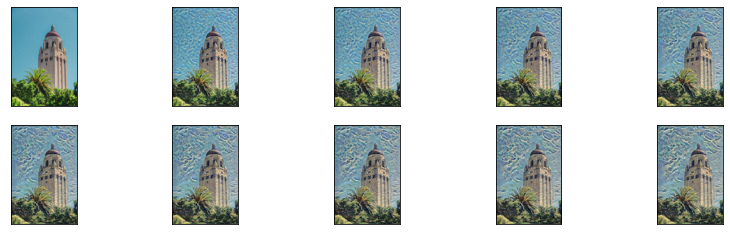

In [73]:
best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=1000)

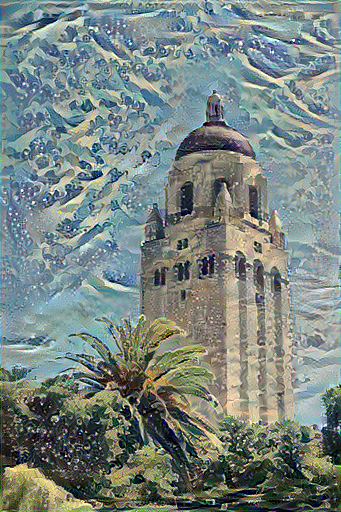

In [74]:
Image.fromarray(best)
